Objective: Classifify images in three categories

Step1: Import All dependencies

```

```



In [4]:
! pip install -q tensorflow
! pip install -q gradio


In [5]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.15.0


Step 2: Load Dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!dir

cnn_model_50.h5  Multi_Class_Image_Classification_Using_CNN.ipynb
dataset.rar	 MultiClass\ _Image_Classification_Using_CNN.ipynb.ipynb
FINAL_CNN.html	 test_examples.rar


In [9]:

!pip install patool


In [10]:
import patoolib
patoolib.extract_archive("dataset.rar")
patoolib.extract_archive("test_examples.rar")

INFO patool: Extracting dataset.rar ...
INFO:patool:Extracting dataset.rar ...
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN/dataset.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN/dataset.rar"
INFO patool:     with cwd='./Unpack_c9dim25w', input=''
INFO:patool:    with cwd='./Unpack_c9dim25w', input=''
INFO patool: ... dataset.rar extracted to `dataset'.
INFO:patool:... dataset.rar extracted to `dataset'.
INFO patool: Extracting test_examples.rar ...
INFO:patool:Extracting test_examples.rar ...
INFO patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN/test_examples.rar"
INFO:patool:running /usr/bin/unrar x -- "/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN/test_examples.rar"
INFO patool:     with cwd='./Unpack_cqaz4jx3', input=''
INFO:patool:

'test_examples'

Step 3: Build CNN Model

In [11]:
# create CNN model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):

        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth) # (h, h, chanel)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(150, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # third set of CONV => RELU => POOL layers
        model.add(Conv2D(200, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # ------------------------ANN-----------------------
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(2000))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model


Step 4: Data Reading

In [12]:
DATASET= "dataset" # this folder must contain three subfolder with images
MODEL="Scene.model"# name to store the model on dis
PLOT="plot.png" # plot name

In [13]:
# initialize the data and labels
print("[INFO] loading images...")
data = []  # x
labels = [] # y

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar
with tqdm(total=len(imagePaths)) as pbar:

    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        if label == "Buildings":
            label = 0
        elif label == "Forest":
            label = 1
        elif label == "Sea":
            label = 2

        labels.append(label)

        # update the progressbar
        pbar.update(1)



[INFO] loading images...


  0%|          | 0/1326 [00:00<?, ?it/s]

In [14]:
# check shape of single image
data[0].shape

(28, 28, 3)

In [15]:
data[0]

array([[[237., 209., 198.],
        [240., 215., 205.],
        [237., 215., 204.],
        ...,
        [188., 143., 116.],
        [200., 156., 125.],
        [195., 138., 106.]],

       [[235., 207., 192.],
        [232., 210., 198.],
        [236., 217., 209.],
        ...,
        [214., 169., 145.],
        [182., 117.,  80.],
        [174., 113.,  77.]],

       [[228., 199., 184.],
        [243., 219., 206.],
        [245., 225., 214.],
        ...,
        [206., 154., 123.],
        [209., 156., 120.],
        [181., 118.,  81.]],

       ...,

       [[155., 164., 172.],
        [143., 152., 165.],
        [137., 149., 155.],
        ...,
        [ 66.,  57.,  54.],
        [ 17.,   9.,   7.],
        [ 14.,   6.,   6.]],

       [[ 97., 113., 129.],
        [113., 129., 141.],
        [119., 130., 140.],
        ...,
        [ 19.,  15.,  16.],
        [ 27.,  25.,  23.],
        [ 15.,  12.,  12.]],

       [[147., 159., 169.],
        [138., 149., 158.],
        [127., 1

Step 5: Data Spliting

In [16]:
# perform data normalisation
data=np.array(data,dtype="float")/255.0
labels = np.array(labels)

In [17]:
data[0]

array([[[0.92941176, 0.81960784, 0.77647059],
        [0.94117647, 0.84313725, 0.80392157],
        [0.92941176, 0.84313725, 0.8       ],
        ...,
        [0.7372549 , 0.56078431, 0.45490196],
        [0.78431373, 0.61176471, 0.49019608],
        [0.76470588, 0.54117647, 0.41568627]],

       [[0.92156863, 0.81176471, 0.75294118],
        [0.90980392, 0.82352941, 0.77647059],
        [0.9254902 , 0.85098039, 0.81960784],
        ...,
        [0.83921569, 0.6627451 , 0.56862745],
        [0.71372549, 0.45882353, 0.31372549],
        [0.68235294, 0.44313725, 0.30196078]],

       [[0.89411765, 0.78039216, 0.72156863],
        [0.95294118, 0.85882353, 0.80784314],
        [0.96078431, 0.88235294, 0.83921569],
        ...,
        [0.80784314, 0.60392157, 0.48235294],
        [0.81960784, 0.61176471, 0.47058824],
        [0.70980392, 0.4627451 , 0.31764706]],

       ...,

       [[0.60784314, 0.64313725, 0.6745098 ],
        [0.56078431, 0.59607843, 0.64705882],
        [0.5372549 , 0

In [18]:
 #Split the data into train test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [19]:
# verify shapes
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(994, 28, 28, 3)
(332, 28, 28, 3)
(994,)
(332,)


In [20]:
testY

array([0, 1, 1, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0,
       1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0,
       2, 1, 1, 0, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2,
       0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       2, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 0, 2, 0,
       0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 2, 0, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 1, 2, 2, 2, 0, 1, 2, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 2,
       0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1, 2, 1, 0, 0,
       0, 0, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 1, 1, 0, 0,
       0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 2,
       2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 1,

In [21]:
# Perform one hot label encoding
trainY = to_categorical(trainY, num_classes=3)
testY = to_categorical(testY, num_classes=3)

In [22]:
trainY[0]

array([1., 0., 0.], dtype=float32)

Step 6: Data Preprocessing (Augumentation)

In [23]:
# construct the image generator for data augmentation
aug= ImageDataGenerator(rotation_range=30,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode="nearest")

Step 7: Compile and Training

In [24]:
INIT_LR = 1e-3
BS = 32

# initialize the model
print("[INFO] compiling model...")
model=LeNet.build(width=28,height=28,depth=3,classes=3)
opt= Adam(learning_rate=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] model complied...")



[INFO] compiling model...
[INFO] model complied...


In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 50)        3800      
                                                                 
 activation (Activation)     (None, 28, 28, 50)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 50)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 150)       187650    
                                                                 
 activation_1 (Activation)   (None, 14, 14, 150)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 150)         0         
 g2D)                                                   

In [26]:
# train the network
EPOCH = 50
print("[INFO] training network....")
H= model.fit(x=aug.flow(trainX,trainY,batch_size=BS),
             validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCH,
              verbose=1)

# save the model and label binarizer to disk
print("[INFO] serializing network ...")
model.save("cnn_model_{}.h5".format(EPOCH))




[INFO] training network....
Epoch 1/50
31/31 [==============================] - 8s 71ms/step - loss: 1.0094 - accuracy: 0.5010 - val_loss: 0.7147 - val_accuracy: 0.6928
Epoch 2/50
31/31 [==============================] - 1s 22ms/step - loss: 0.8036 - accuracy: 0.6227 - val_loss: 0.7188 - val_accuracy: 0.6687
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 0.7293 - accuracy: 0.6632 - val_loss: 0.7046 - val_accuracy: 0.7078
Epoch 4/50
31/31 [==============================] - 1s 23ms/step - loss: 0.7196 - accuracy: 0.6809 - val_loss: 0.6865 - val_accuracy: 0.7229
Epoch 5/50
31/31 [==============================] - 1s 23ms/step - loss: 0.6241 - accuracy: 0.7349 - val_loss: 0.4606 - val_accuracy: 0.8042
Epoch 6/50
31/31 [==============================] - 1s 22ms/step - loss: 0.6049 - accuracy: 0.7464 - val_loss: 0.5156 - val_accuracy: 0.7982
Epoch 7/50
31/31 [==============================] - 1s 21ms/step - loss: 0.5461 - accuracy: 0.7817 - val_loss: 0.5220 - val_ac

Step 8: Model Evaluation

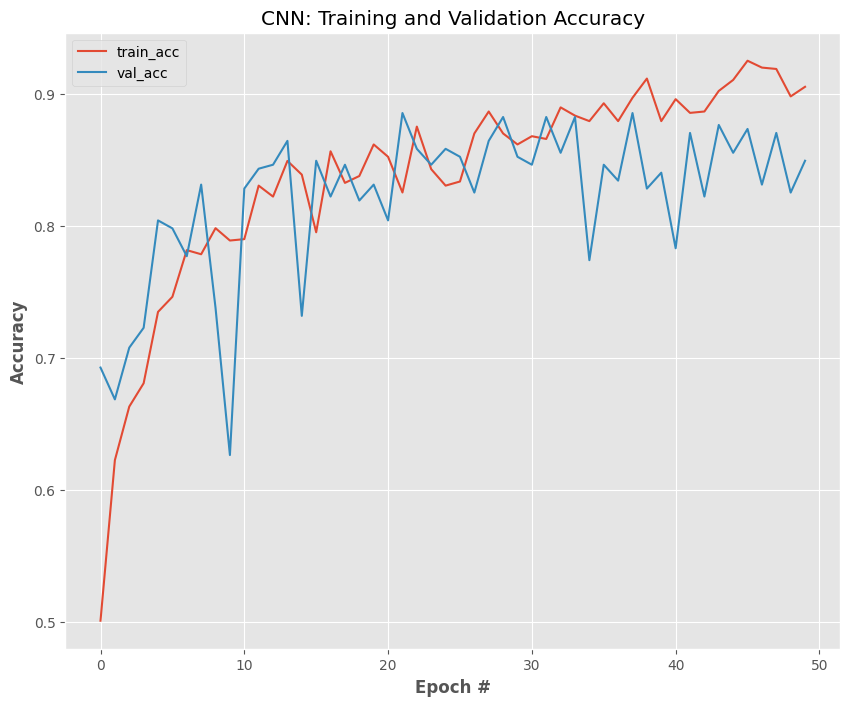

In [27]:
# plot the training and validation accuracy
N = np.arange(0, EPOCH )
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

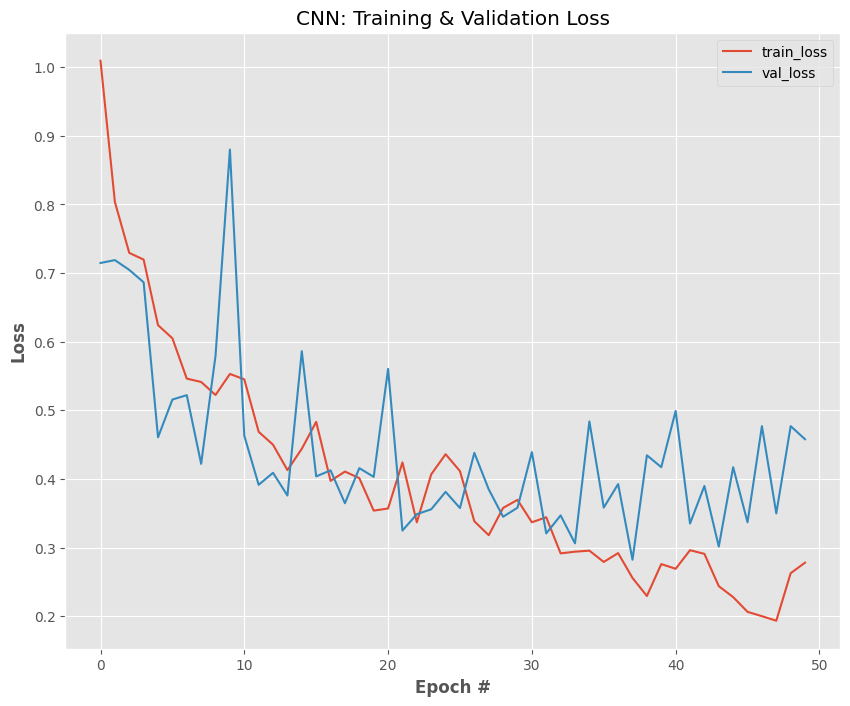

In [28]:
# plot the training and validation loss
N = np.arange(0, EPOCH)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

Confusion Matrix

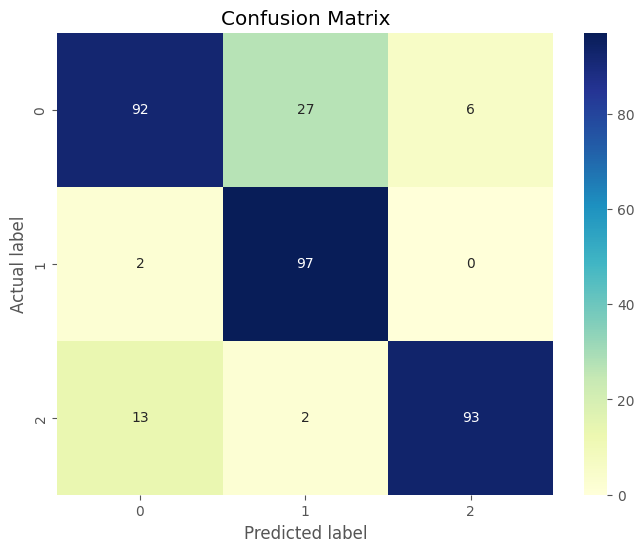


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       125
           1       0.77      0.98      0.86        99
           2       0.94      0.86      0.90       108

    accuracy                           0.85       332
   macro avg       0.86      0.86      0.85       332
weighted avg       0.86      0.85      0.85       332



In [32]:
# Assuming you have defined y_test and y_pred earlier or from your model predictions
# Example:
y_test = actual_classes
y_pred = predicted_classes

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Calculate and print the Classification Report
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Step 9: Prediction on Unseen Data

In [33]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)

  0%|          | 0/28 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  4%|▎         | 1/28 [00:00<00:03,  6.95it/s]

[0.56444573 0.06998564 0.3655686 ]
1/1 [==============================] - 0s 17ms/step
[0.257111   0.73741686 0.00547208]
1/1 [==============================] - 0s 17ms/step


 11%|█         | 3/28 [00:00<00:02,  9.83it/s]

[0.03927499 0.02638899 0.934336  ]
1/1 [==============================] - 0s 20ms/step
[0.00679145 0.16123104 0.83197755]
1/1 [==============================] - 0s 19ms/step
[0.18470265 0.00706683 0.80823046]


 18%|█▊        | 5/28 [00:00<00:02, 10.50it/s]

1/1 [==============================] - 0s 18ms/step
[1.0017570e-01 1.6020221e-04 8.9966404e-01]
1/1 [==============================] - 0s 18ms/step
[0.01302703 0.01032175 0.97665125]


 25%|██▌       | 7/28 [00:00<00:01, 10.60it/s]

1/1 [==============================] - 0s 17ms/step
[0.01056753 0.01082154 0.97861093]
1/1 [==============================] - 0s 16ms/step
[3.8310650e-04 3.8503404e-03 9.9576652e-01]


 32%|███▏      | 9/28 [00:00<00:01, 10.79it/s]

1/1 [==============================] - 0s 17ms/step
[0.0747823  0.16433965 0.760878  ]
1/1 [==============================] - 0s 19ms/step
[0.87234414 0.00369883 0.12395702]


 39%|███▉      | 11/28 [00:01<00:01, 10.92it/s]

1/1 [==============================] - 0s 20ms/step
[0.6086292  0.3869466  0.00442412]
1/1 [==============================] - 0s 18ms/step
[0.16493545 0.83091927 0.0041453 ]


 46%|████▋     | 13/28 [00:01<00:01, 10.93it/s]

1/1 [==============================] - 0s 17ms/step
[0.9261783  0.03949699 0.03432473]
1/1 [==============================] - 0s 17ms/step
[4.3187261e-02 9.5680916e-01 3.5604155e-06]


 54%|█████▎    | 15/28 [00:01<00:01, 10.84it/s]

1/1 [==============================] - 0s 17ms/step
[9.9163437e-01 8.2040401e-03 1.6163773e-04]
1/1 [==============================] - 0s 17ms/step
[0.9842074  0.00380755 0.01198498]


 61%|██████    | 17/28 [00:01<00:01, 10.90it/s]

1/1 [==============================] - 0s 18ms/step
[0.36250576 0.0510759  0.5864184 ]
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 19/28 [00:01<00:00, 11.06it/s]

[6.6102161e-03 9.9338949e-01 2.6704956e-07]
1/1 [==============================] - 0s 17ms/step
[3.2080643e-04 9.9967897e-01 2.1804702e-07]
1/1 [==============================] - 0s 18ms/step
[3.5435132e-05 9.9996448e-01 1.2230321e-07]


 75%|███████▌  | 21/28 [00:01<00:00, 11.03it/s]

1/1 [==============================] - 0s 17ms/step
[6.9879028e-03 9.9286872e-01 1.4334361e-04]
1/1 [==============================] - 0s 19ms/step
[1.4067056e-07 9.9999988e-01 5.6797650e-11]


 82%|████████▏ | 23/28 [00:02<00:00, 10.92it/s]

1/1 [==============================] - 0s 18ms/step
[7.2909740e-04 9.9925560e-01 1.5272024e-05]
1/1 [==============================] - 0s 18ms/step
[9.6631242e-04 9.9902046e-01 1.3164218e-05]


 89%|████████▉ | 25/28 [00:02<00:00, 10.77it/s]

1/1 [==============================] - 0s 18ms/step
[0.00464251 0.9942367  0.00112079]
1/1 [==============================] - 0s 23ms/step
[1.3744735e-06 9.9999857e-01 6.2528325e-12]


 96%|█████████▋| 27/28 [00:02<00:00, 10.74it/s]

1/1 [==============================] - 0s 18ms/step
[1.0953154e-05 9.9998903e-01 9.0804564e-10]


100%|██████████| 28/28 [00:02<00:00, 10.72it/s]


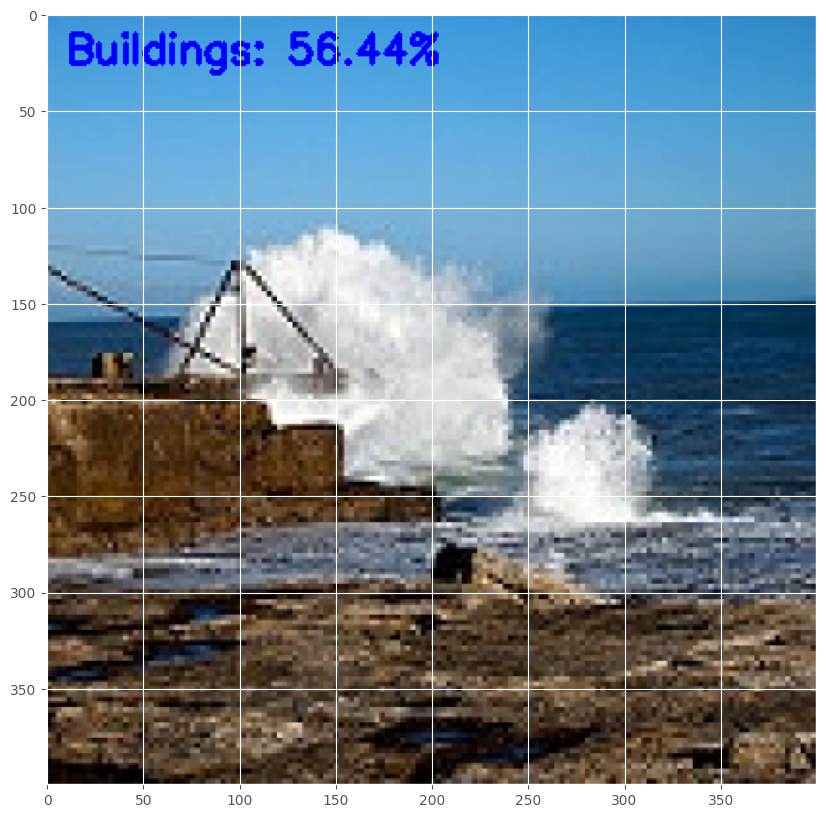

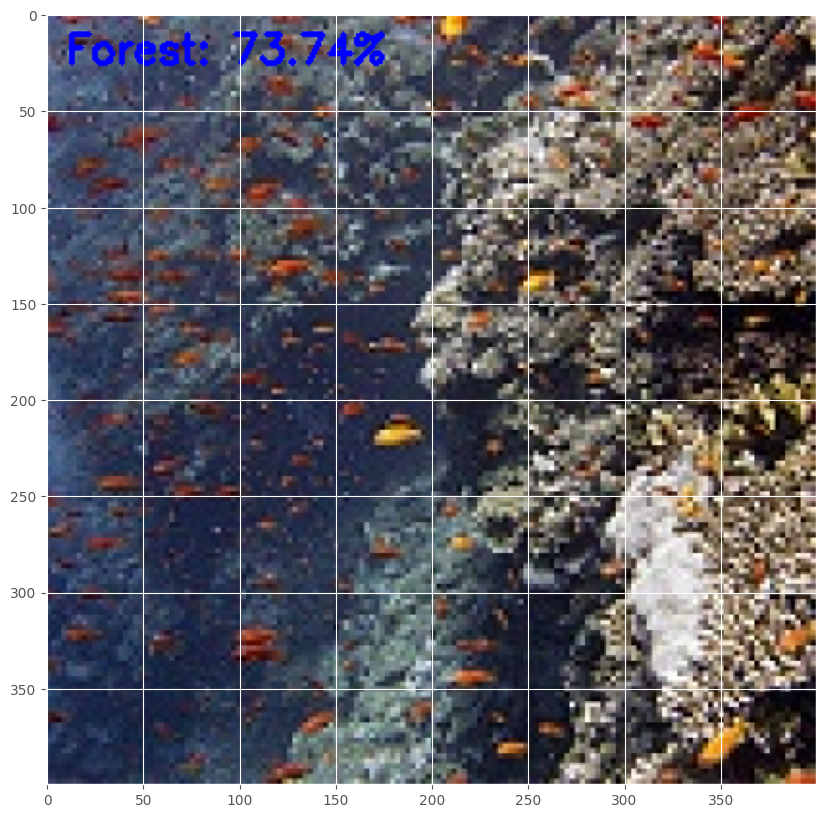

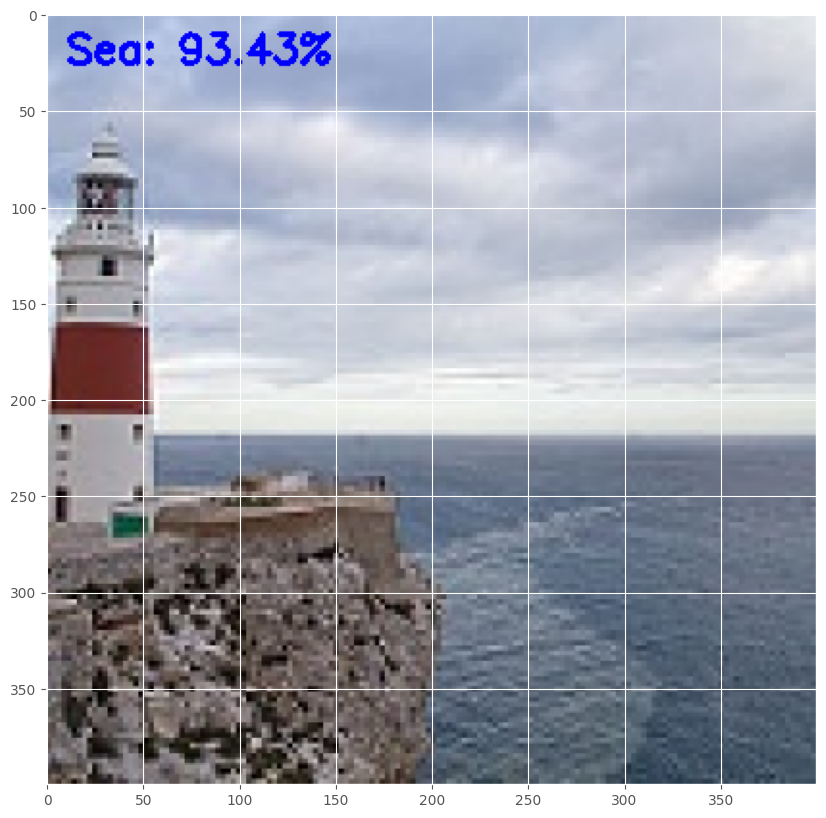

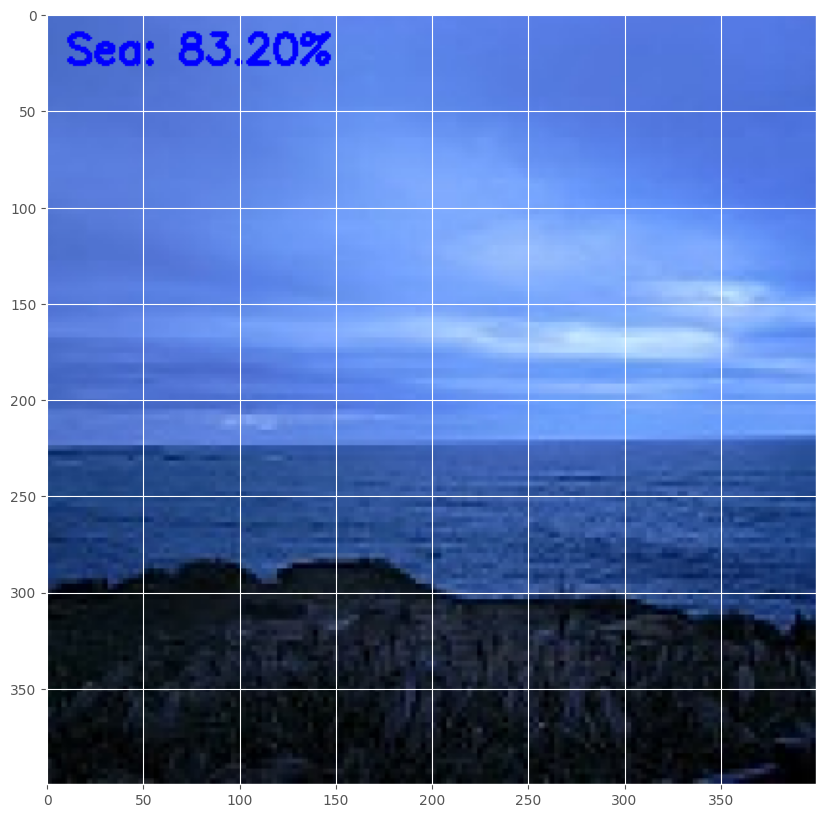

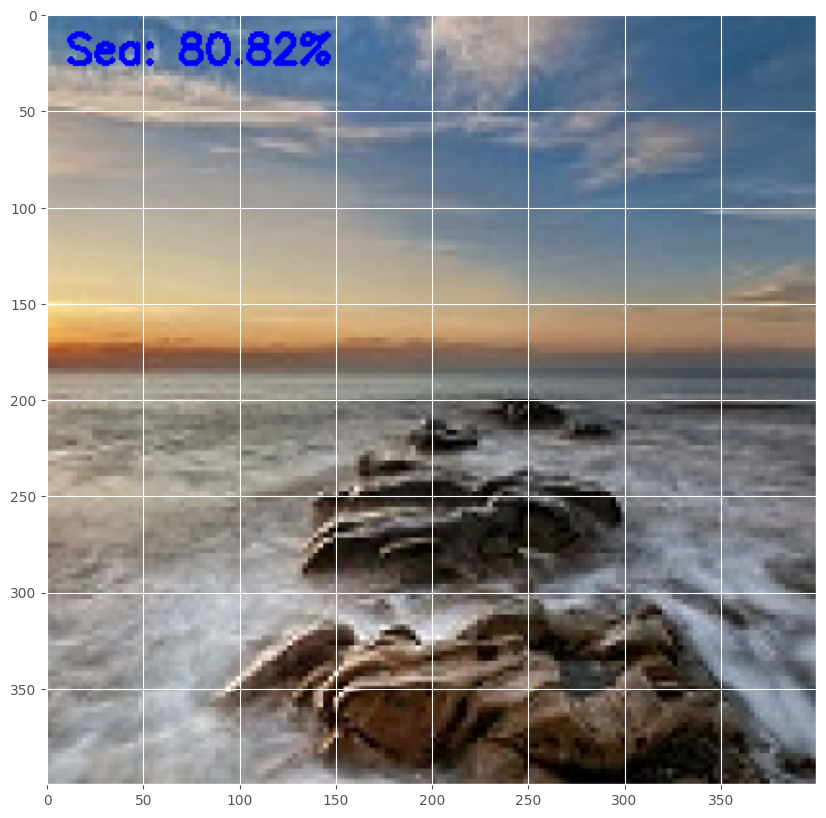

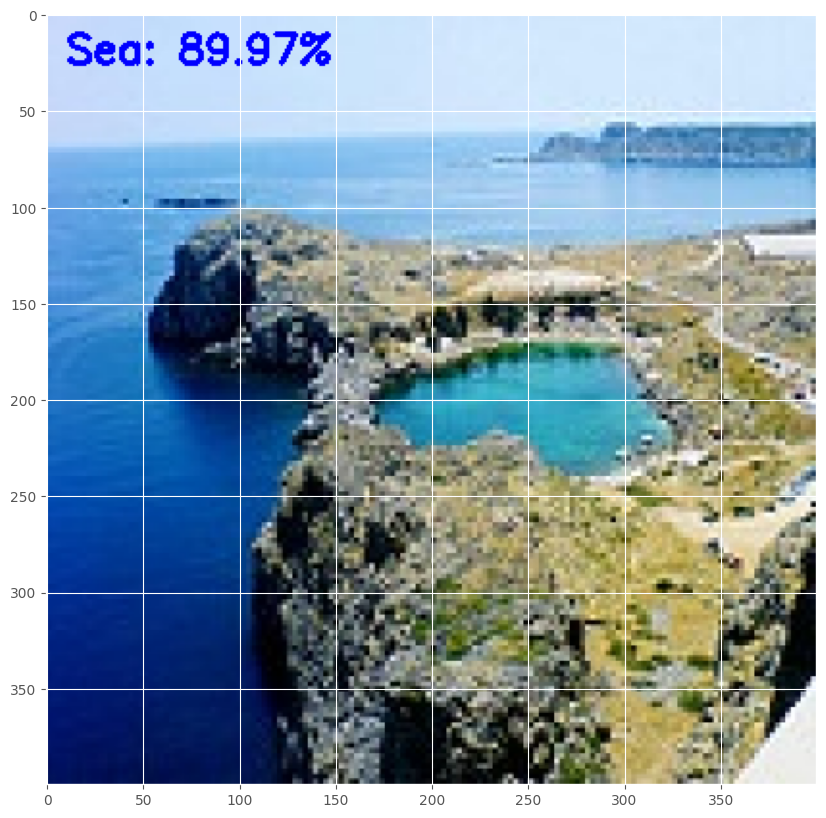

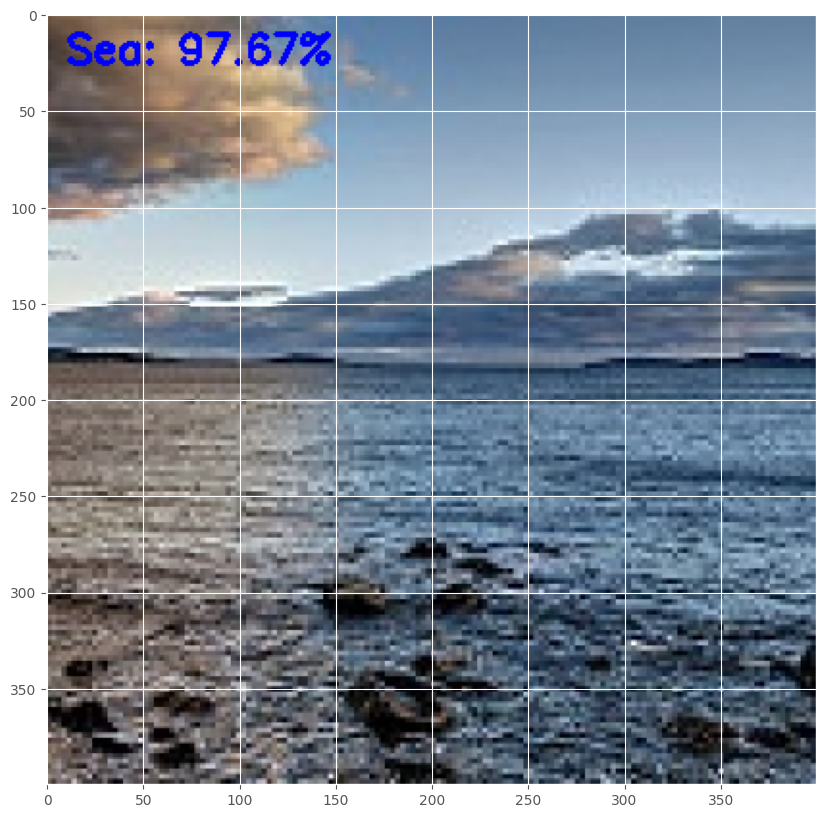

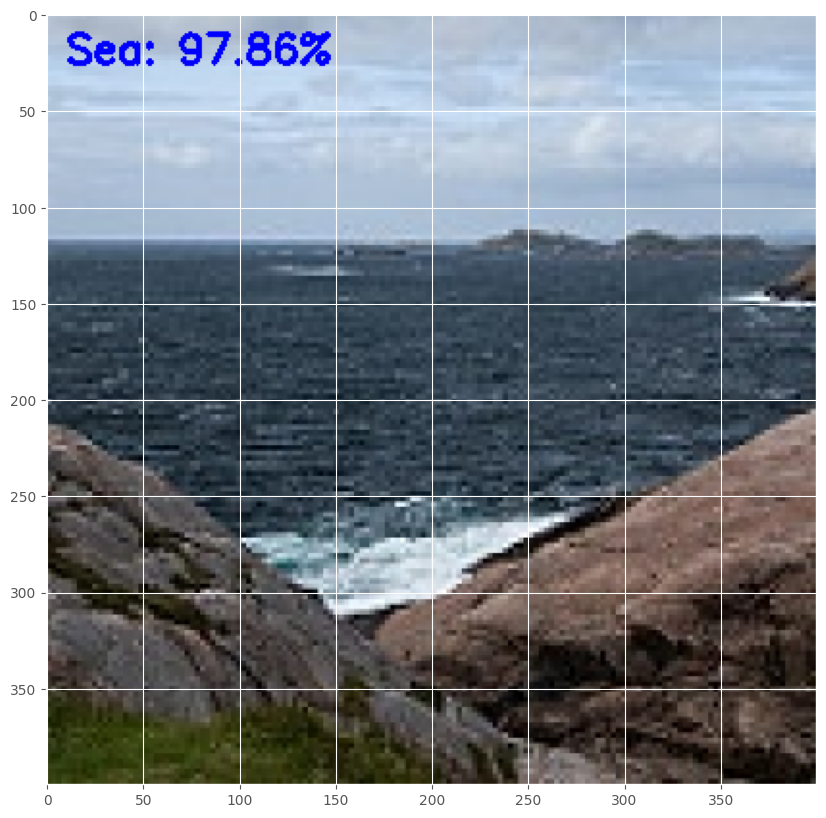

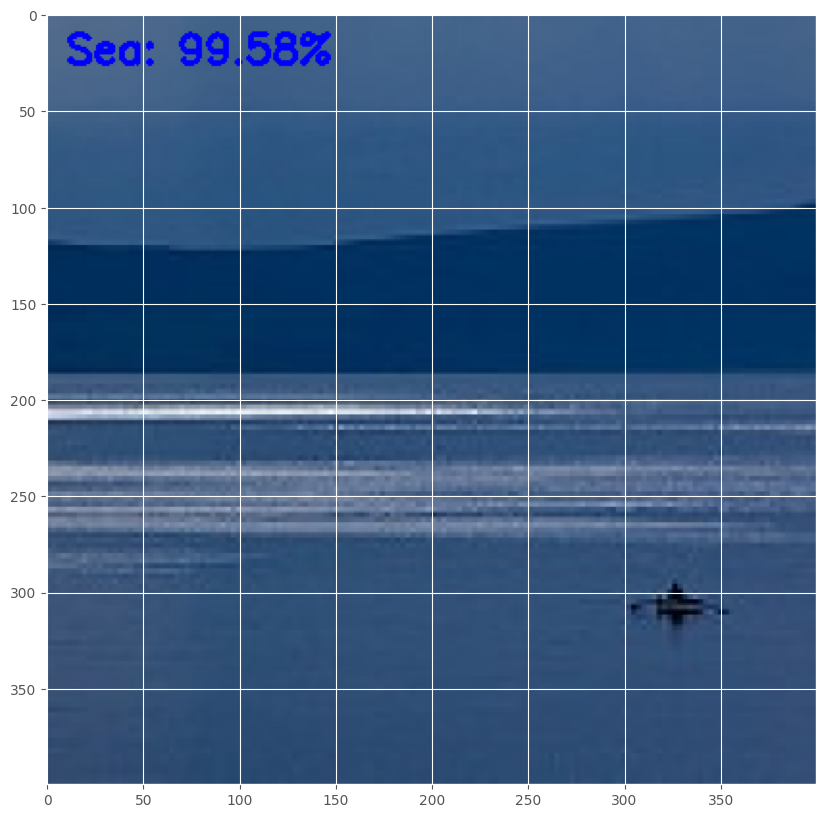

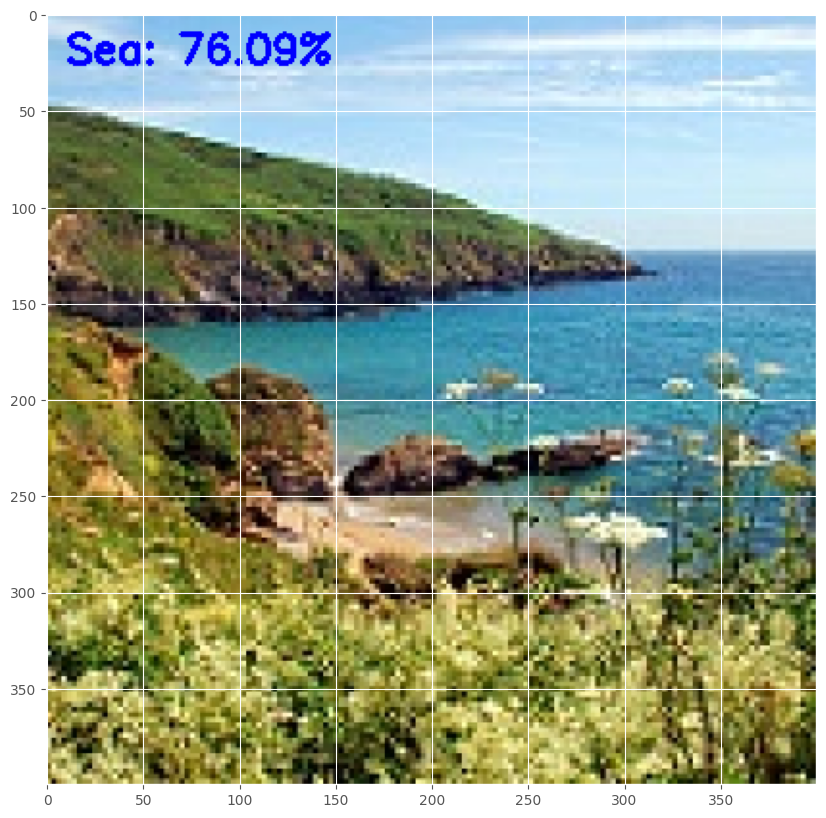

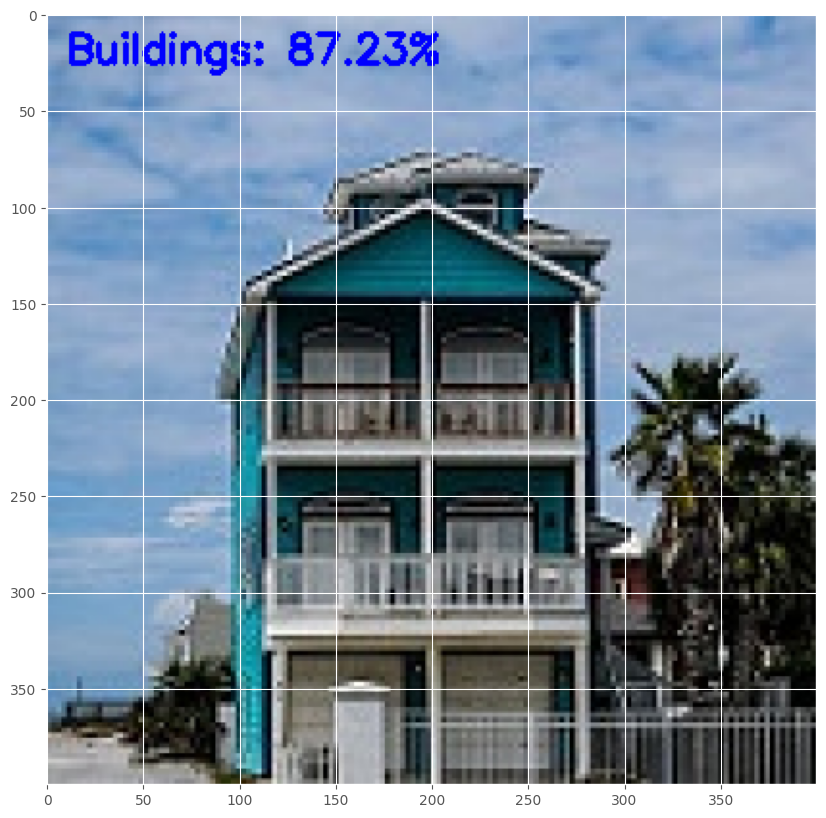

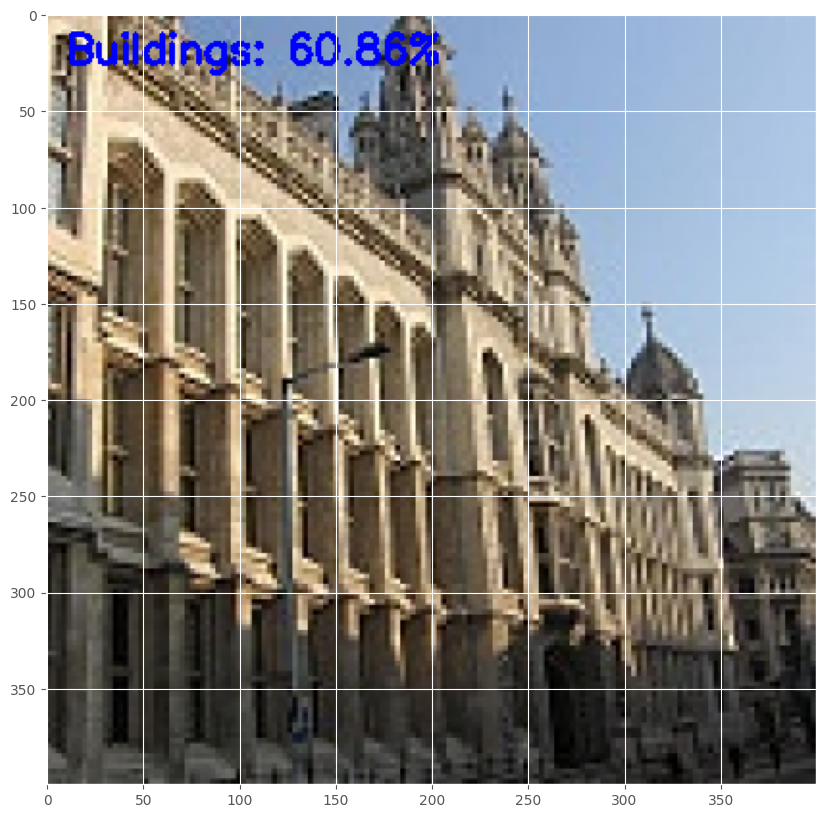

In [ ]:
import cv2
import numpy as np
import imutils
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

from imutils import paths  # Add this line to import paths from imutils



# grab the image paths and randomly shuffle theme

testImagePaths= sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class= ["Buildings", "Forest", "Sea"]

#progressbar

with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf= model.predict(image)[0] # [[0.1 , 0.8 , 0.1]]
        print(prd_conf)

        # build the label
        label = all_class[np.argmax(prd_conf)] #[b f s]-> f
        proba = prd_conf[np.argmax(prd_conf)] # [0.1 , 0.8 , 0.1]  -> 0.8

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)

        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)

Step 10: Deployment on Gradio

In [35]:
import gradio as gr
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from imutils import paths
%matplotlib inline

In [36]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ Deep Learning Projects/ Image classification using CNN")

# # load the model
print("[INFO] loading network and...")
model = load_model("cnn_model_{}.h5".format(EPOCH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] loading network and...


In [38]:
def predict_image(image):


    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)

    print(result)

    return result

In [41]:
!pip install gradio==3.50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 0.16.0
    Uninstalling gradio_client-0.16.0:
      Successfully uninstalled gradio_client-0.16.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.28.3
    Uninstalling gradio-4.28.3:
      Successfully uninstalled gradio-4.28.3


In [49]:
im = gr.Image()
label = gr.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label, title="CNN Demo").launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Could not create share link. Missing file: /usr/local/lib/python3.10/dist-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.10/dist-packages/gradio


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
